## TODO:
- pathRegister.csv (stationID, weatherComponent, relativePath)
    - file
    - read pathRegister.csv
    - getAbsolutePath

- sampleForDependentComponent
    - limit number of iteration -> return NaN if no sample is found (infinite loop if probability function is zero)
- weather components:
    - add missing components

In [1]:
from enum import Enum, auto
import pathlib
import datetime, time
from scipy import stats
from scipy.interpolate import interp1d
import numpy as np
import random
import pandas as pd
import math

import nbimporter
from NameEnums import ContextProperty

ModuleNotFoundError: No module named 'nbimporter'

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl

### Weather data:
- year, month, day, full hour
- weather component value, e.g. rainfall quantity, or temperature

### Sample a random date & time (for a given weather component value)
date: month and day (only interested in "what time of year")<br>
time: full hour<br>
The combination of month, day, and hour is abbreviated as _mdh_.

- Consolidate values, e.g. rainfall quantity, from all available years for each _mdh_
    - `buildGroupsBy('Timestamp')`
    - rainfall quantity is here the `fixedComponent` with a given `fixedValue`
    - mdh is the `dependentComponent` from which we want a sample
- each group gives the distribution of values that have occured at that _mdh_ $\rightarrow$ histogram, probability density function (pdf), kernel density estimation (kde)
    - histogram is not continuous $\rightarrow$ might disregard values that haven't occured before but are near ones that often occured, but easy to get probabilities
- Probability density function (pdf):
    - area under the curve for a certain interval represents the probability that a value lies within the interval
    - area under the whole curve sums up to 1
    - probability for a single value $x$ is 0, because the domain is continuous
    - $pdf(x)$ is relative to the probability for an infinitesimal interval around $x$
    - _kernel density function:_ non-parametric estimation of pdf
- Approximate the probability for a fixed value $x$ with $kde(x)$ at each _mdh_
- These approximate probabilities can be used for rejection sampling
    - directly if candidate samples are only the _mdh_s
    - with interpolation to get a continuous function if candidate samples include minutes and seconds as well


__Improvement ideas:__
- add random number of minutes/seconds to the full hour (after sampling for simplification)


### Sample a random value $x$ from distribution $X$ under condition of given value $y$ from distribution $Y$
e.g. sample a temperature $x$ under the condition that the rainfall quantity $y$ at _mdh_ $t$

- Analogous procedure with:
    - temperature as `dependentComponent`
    - rainfall quanitity as `fixedComponent` with given `fixedValue`
- Not every temperature-value might occur in the data, therefore there are values missing in the index of the probability DataFrame `probDf`
    - replace index with range from lowest to highest temperature with stepsize 0.1
    - _check if regular stepsize is 0.1 for all weather component data_

__Improvement ideas:__
- enhance index at beginning and end (e.g. with the size of `smoothWindow`) to allow values that did not occur yet but are nearby

### Special case: Sample a value from some weather component with given MDH
e.g. get a sample temperature for a given MDH

- Approach 1: convert date to integer, and then build kde analogously to above cases -> result is not realistic
- Approach 2:
    - for MDH we do not have the problem that we might have none or too less values corresponding to one MDH
    - get corresponding values from the `dependentComponent` for the given MDH
    - get $kde(x)$ for each $x$ from `dependentComponent`
    - still remaining problem: values from MDHs before and after are not incoorperated

__Improvement ideas:__
- compute kde-values for MDHs before and after the given one -> weighted average of results

### Get a sample dependent on several other weather components
e.g. get a sample temperature for a given rain quantity on a certain MDH

- give a DataFrame `weatherProperties` with the name of the weather component as index and the corresponding given value in the column 'Value'
- probability functions are computed for all weather components in `weatherProperties`
- for the rejection sampling, the sample has to be in agreement with all probability functions, otherwise it is rejected

In [3]:
class WeatherDistribution:
    def __init__(self, stationId, rootPath):
        self.stationID = stationId  # id of station
        self.rootPath = rootPath  # contains: - pathRegister.csv with relative path of data for each station and weather component
                                  #           - weather data
        self.weatherData = pd.DataFrame()  # weather data with 'Timestamp' as index, and a column for each WeatherComponent

    def getAbsolutePath(self, weatherComponent):
        # TODO
        # relative path of the data for this station and given weatherComponent is in pathRegister.csv (-> self.pathRegister)
        ## relativePath = self.pathRegister.loc(stationID, weatherComponent)['PATH']
        ## concat self.rootPath with relativePath -> return
        
        # test-path
        if weatherComponent == ContextProperty.TEMPERATURE.name:
            testPath = pathlib.Path(r'C:\Users\joeckel\Documents\Projekte\Crest\Wetterdaten_ClimateDataCenter\cdc_download_2019-01-03_11_38_temperature\TT_TU_MN009.txt')
        else:
            testPath = pathlib.Path(r'C:\Users\joeckel\Documents\Projekte\Crest\Wetterdaten_ClimateDataCenter\cdc_download_2019-01-14_13_23_precipitation\R1_MN008.txt')
        return testPath
    
    def readWeatherData(self):
        # read data for each weather component into DataFrame weatherData
        
        # TODO
        ##self.pathRegister = pd.read_csv() # read pathRegister.csv into DataFrame
        
        # read data for each weather component into DataFrame weatherData
        for weatherComp in ?:
            # get path where the data can be found
            path = self.getAbsolutePath(weatherComp.name)
            
            # read data for weatherComp
            file = pd.read_csv(path, sep=';', encoding='latin1', parse_dates=['ZEITSTEMPEL'],index_col='ZEITSTEMPEL')
            file.index.rename('Timestamp', inplace=True)  # index column is named 'Timestamp' -> original timestamp      
            file.rename(columns={'WERT': weatherComp.name}, inplace=True) # column in DataFrame weatherData has weathercomponent as name
            
            # concat into altogether DataFrame weatherData
            if self.weatherData.empty:
                self.weatherData = file[weatherComp.name].to_frame()
            else:
                self.weatherData = self.weatherData.join(file[weatherComp.name])
        
        
        # copy column 'Timestamp' in new colum 'MDH' and set every year to 2240 (-> leap year and within range of datetimeindex)
        self.weatherData['MDH'] = self.weatherData.index
        self.weatherData['MDH'] = self.weatherData['MDH'].map(lambda t: t.replace(year=2240)) 
        
        
        # if some element is NaN -> error when computing probabilities -> replace with 0
        if self.weatherData.isnull().values.any():
            self.weatherData = self.weatherData.fillna(0)
    
    def buildGroupsBy(self, columnGroup):
        # group DataFrame weatherData by given column
        return self.weatherData.groupby([self.weatherData[columnGroup]])
    
    def probabilityFunct(self, fixedComponent, dependentComponent, fixedValue, smoothed=False, smoothWindow=None):
        # build an approximate probability function for the given fixedValue
        # DataFrame weatherData is grouped according to the column of the dependentComponent
        # -> for each value of the dependentComponent we get a group of corresponding values from the column of the fixedComponent
        # fixedComponent-values from each group are used to build a kernel density estimation (kde) to get an approximate probability for fixedValue
        # all kde function values for fixedValue build a probability function (probability of fixedValue for dependentComponent),
        # that can be used for getting a sample value of the dependentComponent with rejection sampling
        
        # grouped weatherData (by dependent component)
        groupedByDependComp = self.buildGroupsBy(dependentComponent)
        
        if fixedComponent != 'MDH':
            # iterate through all groups -> get probability for fixedValue in this group        
            probFixedValue = np.array([self.probabilityForFixedValueInGroup(group[fixedComponent].values, fixedValue) 
                              for dependValue, group in groupedByDependComp])
        else:
            # if MDH in weatherProperties -> group for MDH -> get kde(dependentComponent.keys) in this group as probability
            # for MDH there are always corresponding values from the dependentComponent
            groupMDH = distr.buildGroupsBy('MDH').get_group(fixedValue)    
            probFixedValue = np.array([self.probabilityForFixedValueInGroup(groupMDH[dependentComponent].values, temp) 
                                for temp in groupedByDependComp.groups.keys()])
        
        # divide each element by number of elements
        probFixedValue = np.divide(probFixedValue, len(probFixedValue))
        
        # create new DataFrame probDf consisting of probabilities and the values from the dependent component
        probDf = pd.DataFrame(data=probFixedValue, index=groupedByDependComp.groups.keys(), columns=['Probability'])
        probDf.index.rename(dependentComponent, inplace=True)
        
        # if dependentComponent is not MDH, then there might be some values missing in the index that did not occur during measuring
        # -> extend index
        if dependentComponent != 'MDH':
            newIndex = np.arange(np.min(probDf.index.values), np.max(probDf.index.values) + 0.1, 0.1)
            newIndex = np.round(newIndex, 1)  # round to one decimal place (1.1 might be 1.09999998)
            probDf = probDf.reindex(newIndex, fill_value=0.)  # added values are set to 0
        
        
        # values of the dependent component before and after have "similar" overall weather
        # e.g. days/hours before and after 01.07. 11am do not have significantly different weather (in average)
        # -> smooth values (weighted average)
        if smoothed:
            if smoothWindow == None:
                if dependentComponent == 'MDH':
                    smoothWindow = 120  # 2 days before and after are considered
                else:
                    smoothWindow = 50
            probDf = probDf.rolling(window=smoothWindow, center=True, min_periods=1, win_type='gaussian').mean(std=2)
    
        return probDf
    
    def probabilityFunctMultiple(self, dependentComponent, weatherProperties, smoothed=False, smoothWindow=None):
        # build an approximate probability function for the given fixed values in weatherProperties
        # DataFrame weatherData is grouped according to the column of the dependentComponent
        # -> for each group of the dependentComponent, a probability for each fixed component from weatherProperties is computed
        # -> probability values for each fixed component build a probability function for this component
                
        # weatherProperties: DataFrame extracted from Properties with fixed components and fixed values
        # (fixed components names as index, corresponding values in column 'Value')
        
        
        # grouped weatherData (by dependent component)
        groupedByDependComp = self.buildGroupsBy(dependentComponent)
        
        # compute probability function for each fixed component with its fixed value in DataFrame weatherProperties
        probDf = pd.DataFrame()
        for index, row in weatherProperties.iterrows():
              
            if index != 'MDH':
                # iterate through all groups -> get probability for fixedValue in this group
                probFixedValue = np.array([self.probabilityForFixedValueInGroup(group[index].values, row['Value']) 
                                  for dependValue, group in groupedByDependComp])
            else:
                # if MDH in weatherProperties -> group for MDH -> get kde(dependentComponent.keys) in this group as probability
                # for MDH there are always corresponding values from the dependentComponent
                groupMDH = distr.buildGroupsBy('MDH').get_group(row['Value'])    
                probFixedValue = np.array([self.probabilityForFixedValueInGroup(groupMDH[dependentComponent].values, temp) 
                                  for temp in groupedByDependComp.groups.keys()])
            
            # divide each element by number of elements
            probFixedValue = np.divide(probFixedValue, len(probFixedValue))
            
            newColumnName = 'Probability_' + index
            if probDf.empty:        
                # create new DataFrame probDf consisting of probabilities and the values from the dependent component
                probDf = pd.DataFrame(data=probFixedValue, index=groupedByDependComp.groups.keys(), columns=[newColumnName])
                probDf.index.rename(dependentComponent, inplace=True)
            else:
                probDf[newColumnName] = probFixedValue

        
        # if dependentComponent is not MDH, then there might be some values missing in the index that did not occur during measuring
        # -> extend index
        if dependentComponent != 'MDH':
            newIndex = np.arange(np.min(probDf.index.values), np.max(probDf.index.values) + 0.1, 0.1)
            newIndex = np.round(newIndex, 1)  # round to one decimal place (1.1 might be 1.09999998)
            probDf = probDf.reindex(newIndex, fill_value=0.)  # added values are set to 0
        
        
        # values of the dependent component before and after have "similar" overall weather
        # e.g. days/hours before and after 01.07. 11am do not have significantly different weather (in average)
        # -> smooth values (weighted average)
        if smoothed:
            if smoothWindow == None:
                if dependentComponent == 'MDH':
                    smoothWindow = 120  # 2 days before and after are considered
                else:
                    smoothWindow = 50
            probDf = probDf.rolling(window=smoothWindow, center=True, min_periods=1, win_type='gaussian').mean(std=2)
    
        return probDf
    
    def probabilityForFixedValueInGroup(self, group, fixedValue):
        # compute kernel density estimation (kde) for a given group of values
        # return kde(fixedValue)
        
        if type(fixedValue) == pd.Timestamp:
            group = pd.to_datetime(group)
            group = [int(str(elem.year) + str(elem.month).zfill(2) + str(elem.day).zfill(2) + str(elem.hour).zfill(2))
                     for elem in group]
            fixedValue = pd.to_datetime(fixedValue)
            fixedValue = int(str(fixedValue.year) + str(fixedValue.month).zfill(2) + 
                             str(fixedValue.day).zfill(2) + str(fixedValue.hour).zfill(2))

        
        if (np.count_nonzero(group) > 0) & (len(group) > 1):  # not all values in the group are zero
            kernel = stats.gaussian_kde(group)
            return kernel(fixedValue)
        else:  # all values in the group are zero
            return 0
    
    def sampleForDependentComponent(self, fixedComponent, dependentComponent, fixedValue):
        # get a sample value from dependent component that corresponds to the probability distribution for a given fixedValue
        # example 1: get a sample MDH (= dependentComponent) for a given temperature, e.g. 20.0° (= fixedValue 20.0° from fixedComponent temperature)
        #            ("I need a MDH on which it is realistic to have a temperature of 20.0°")
        #            -> sampleForDependentComponent(WeatherComponent.TEMPERATURE.name, 'MDH', 20.0)
        # example 2: get a sample temperature (= dependentComponent) for a given rain quantity, e.g. 1.1mm (= fixedValue 1.1mm from fixedComponent rain quantity)
        #            (" I need a temperature that might be during raining with quantity 1.1mm")
        #            -> sampleForDependentComponent(WeatherComponent.RAINQUANTITY.name, WeatherComponent.TEMPERATURE.name, 1.1)
        
        
        # probability distribution
        probDf = self.probabilityFunct(fixedComponent, dependentComponent, fixedValue, smoothed=True)
        
        # rejection sampling:
        # select a value (sample_x) from dependent component, get probability (probSample) for this point
        # check if uniformly random value (sample_y) between 0 and maximum of probability function is smaller or equal than probSample
        # if yes, then return sample_x as sample,
        # otherwise reject and repeat
        rejected = True
        maxProb = probDf['Probability'].max()
        while rejected:
            sample_x = random.choice(probDf.index.values)
            probSample = probDf.loc[sample_x]['Probability']
            sample_y = random.uniform(0, maxProb)
            if sample_y <= probSample:
                rejected = False
                return sample_x
    
    def sampleForDependentComponentMultiple(self, dependentComponent, weatherProperties):
        # get a sample value from dependent component that corresponds to the probability distributions for the given fixed values from the fixed components in weatherProperties
        # example: get a sample temperature (= dependentComponent) for a given rain quantity 1.1mm and MDH 2240-5-5 11am
        #            where rain quantity and MDH occur as rows of the index column in weatherProperties, and 1.1 and 2240-5-5 11am in the column 'Value'
        #            (" I need a temperature that might be during raining with quantity 1.1mm on the 5.5. at 11am")
        
        # weatherProperties: DataFrame extracted from Properties with fixed components and fixed values
        # (fixed components names as index, corresponding values in column 'Value')
        
        
        # probability distribution
        probDf = self.probabilityFunctMultiple(dependentComponent, weatherProperties, smoothed=True)
        
        # rejection sampling:
        # select a value (sample_x) from dependent component,
        # for each fixed component:
        # - get probability (probSample) for this point
        # - check if uniformly random value (sample_y) between 0 and maximum of probability function is smaller or equal than probSample
        # if yes for all fixed components, then return sample_x as sample,
        # otherwise reject and repeat
        rejected = True
        while rejected:
            sample_x = random.choice(probDf.index.values)
            rejected = False
            for componentProb in probDf:
                probSample = probDf.loc[sample_x][componentProb]
                sample_y = random.uniform(0, probDf[componentProb].max())
                
                if sample_y > probSample:
                    rejected = True            
            
            
            if not rejected:
                return sample_x
        
        


In [8]:
path_to_distribution_data = pathlib.Path(r'C:\Users\joeckel\Documents\Projekte\Crest\Wetterdaten_ClimateDataCenter\cdc_download_2019-01-03_11_38_temperature\TT_TU_MN009.txt')

In [9]:
distr = WeatherDistribution(2222, path_to_distribution_data)
#file = distr.readDistribution( path_to_distribution_data)
distr.readWeatherData()

### Probability function for given precipitation value and dependent component "temperature"

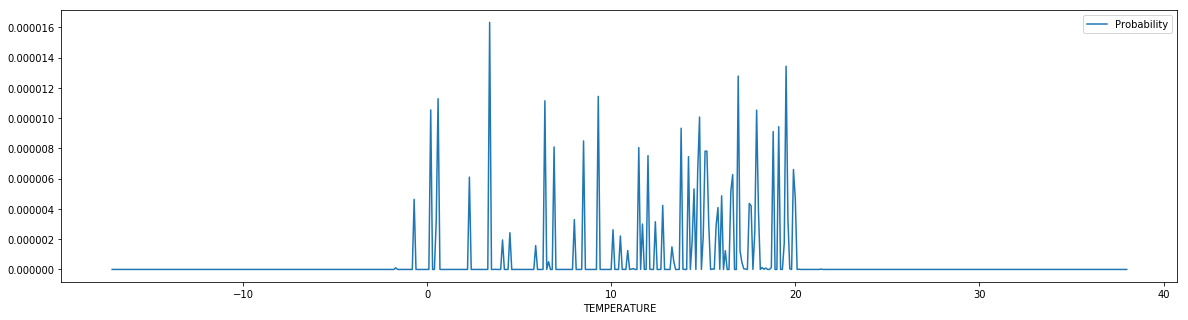

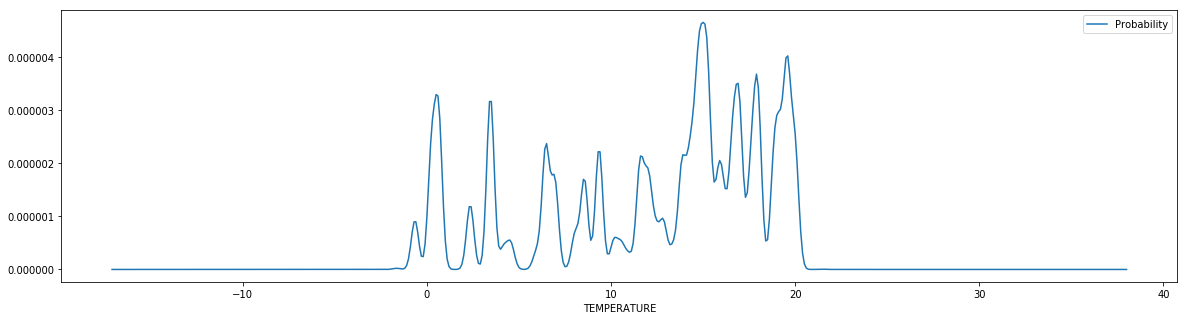

In [34]:
# probability function of precipitation value for temperatures (not smoothed, and smoothed)
precipitation = 5.0
p = distr.probabilityFunct(WeatherComponent.PRECIPITATION.name, WeatherComponent.TEMPERATURE.name, precipitation, smoothed=False)
p.plot(kind="line", figsize=(20,5))
plt.show()
p = distr.probabilityFunct(WeatherComponent.PRECIPITATION.name, WeatherComponent.TEMPERATURE.name, precipitation, smoothed=True)
p.plot(kind="line", figsize=(20,5))
plt.show()

### Sample temperature for given precipitation value

In [35]:
# sample temperature
s = distr.sampleForDependentComponent(WeatherComponent.PRECIPITATION.name, WeatherComponent.TEMPERATURE.name, precipitation)
print(s)

11.7


### Probability function for given precipitation value and dependent component "temperature"

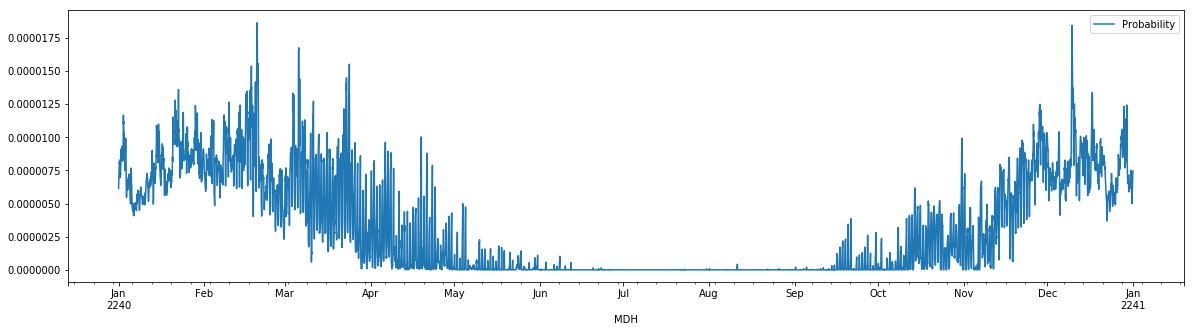

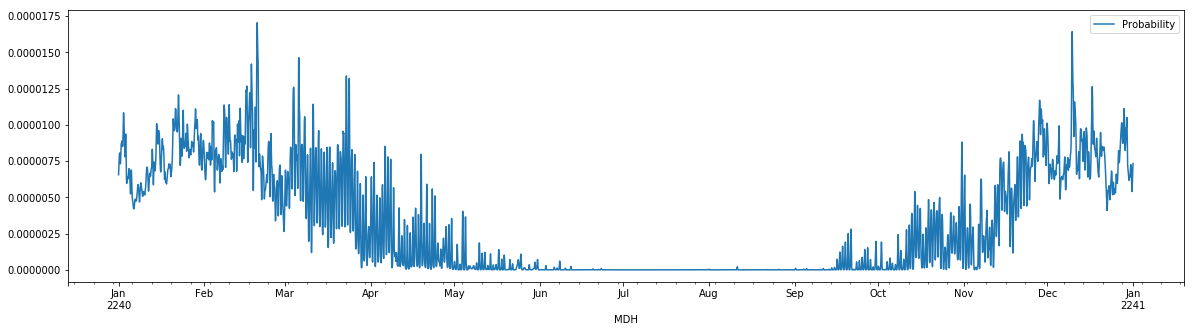

In [42]:
# probability function of temperature value for MDHs (not smoothed, and smoothed)
temperature = 0.4
p = distr.probabilityFunct(WeatherComponent.TEMPERATURE.name, 'MDH', temperature, smoothed=False)
p.plot(kind="line", figsize=(20,5))
#p[:1000].plot(kind="line", figsize=(20,5))
plt.show()
p = distr.probabilityFunct(WeatherComponent.TEMPERATURE.name, 'MDH', temperature, smoothed=True)
p.plot(kind="line", figsize=(20,5))
#p[:1000].plot(kind="line", figsize=(20,5))
plt.show()

### Sample temperature for given precipitation value

In [37]:
# sample MDH
s = distr.sampleForDependentComponent(WeatherComponent.TEMPERATURE.name, 'MDH', temperature)
print(s)

2240-02-28T17:00:00.000000000


### Probability functions for given precipitation value on MDH for dependent component "temperature"

                             Value
Property                          
PRECIPITATION                  1.1
MDH            2240-12-05 12:00:00


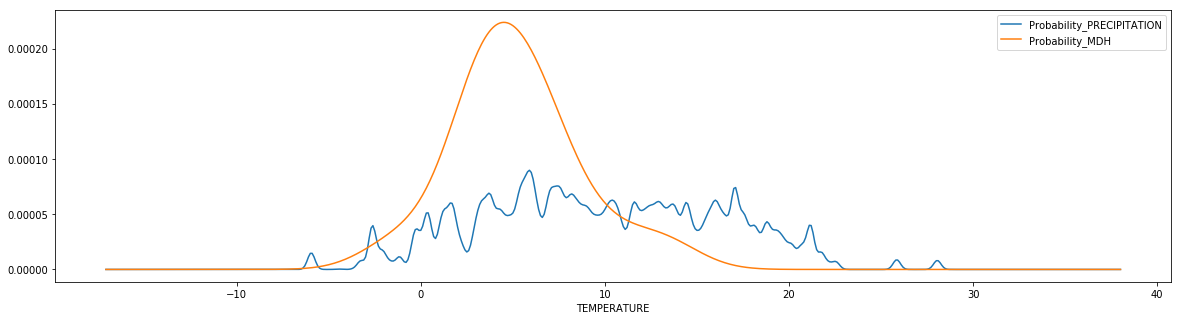

In [48]:
# create DataFrame with precipitation value and MDH
#data = {'Property': [WeatherComponent.PRECIPITATION.name], 'Value': [1.1]}
#data = {'Property': ['MDH'], 'Value': [pd.Timestamp(2240,5,5,12)]}
data = {'Property': [WeatherComponent.PRECIPITATION.name, 'MDH'], 'Value': [1.1, pd.Timestamp(2240,12,5,12)]}
weatherProperties = pd.DataFrame(data)
weatherProperties = weatherProperties.set_index('Property')

print (weatherProperties)

# DataFrame with probability functions for precipitation and MDH
p = distr.probabilityFunctMultiple(WeatherComponent.TEMPERATURE.name, weatherProperties, smoothed=True)
p.plot(kind="line", figsize=(20,5))
plt.show()


### Sample temperature for given precipitation value on MDH

(array([ 3., 12., 18., 27., 17., 13.,  4.,  2.,  3.,  1.]),
 array([-1.2 ,  0.64,  2.48,  4.32,  6.16,  8.  ,  9.84, 11.68, 13.52,
        15.36, 17.2 ]),
 <a list of 10 Patch objects>)

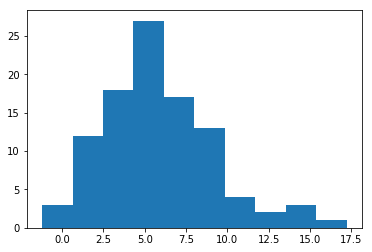

In [27]:
samples = np.array([distr.sampleForDependentComponentMultiple(WeatherComponent.TEMPERATURE.name, weatherProperties)
                    for i in range(100)])
plt.hist(samples)

In [28]:
#print (distr.weatherData)

In [29]:
#pd.date_range(start='2240-01-1', end='2240-12-31', freq='H')[1400:1500]

data = {'score': [1,1,1,2,2,2,3,3,3]}
df = pd.DataFrame(data)
df.rolling(window=3, center=True, min_periods=1).mean()

,score
0,1.000000
1,1.000000
2,1.333333
3,1.666667
4,2.000000
5,2.333333
6,2.666667
7,3.000000
8,3.000000


In [6]:
keys=[1,2,3,4]
d = [1,1,1,1]
df = pd.DataFrame()
for i in range(2):
    colName = 'col' + str(i)
    if df.empty:
        
        df = pd.DataFrame(data=d, index=keys, columns=[colName])
        df.index.rename('index', inplace=True)
    else:
        df[colName] = [(1,2),2,2,2]

df.loc[5] = [3, 4]
df

,col0,col1
index,,
1,1,"(1, 2)"
2,1,2
3,1,2
4,1,2
5,3,4
